In [38]:
#首先进行加载数据
import pandas as pd
data = pd.read_csv('./train.csv')
print(data.head())#数据前5行，查看一下数据结构，方便进行数据调整
print(data.Datetime)

   ID          Datetime  Count
0   0  25-08-2012 00:00      8
1   1  25-08-2012 01:00      2
2   2  25-08-2012 02:00      6
3   3  25-08-2012 03:00      2
4   4  25-08-2012 04:00      2
0        25-08-2012 00:00
1        25-08-2012 01:00
2        25-08-2012 02:00
3        25-08-2012 03:00
4        25-08-2012 04:00
               ...       
18283    25-09-2014 19:00
18284    25-09-2014 20:00
18285    25-09-2014 21:00
18286    25-09-2014 22:00
18287    25-09-2014 23:00
Name: Datetime, Length: 18288, dtype: object


In [39]:
#因为数据只有两列，已经满足格式需求，所以暂时不需要进行字段选择，但是需要进行转换时间格式并作为索引
#data.index = pd.to_datetime(data.Datetime)#pd中应该是有这种时间格式的，所以自动识别成了正式格式，其实也能用，但是为了保险起见，还是加一下指定性格式转换
data.index = pd.to_datetime(data.Datetime,format = '%d-%m-%Y %H:%M')
data

,ID,Datetime,Count
Datetime,,,
2012-08-25 00:00:00,0,25-08-2012 00:00,8
2012-08-25 01:00:00,1,25-08-2012 01:00,2
2012-08-25 02:00:00,2,25-08-2012 02:00,6
2012-08-25 03:00:00,3,25-08-2012 03:00,2
2012-08-25 04:00:00,4,25-08-2012 04:00,2
...,...,...,...
2014-09-25 19:00:00,18283,25-09-2014 19:00,868
2014-09-25 20:00:00,18284,25-09-2014 20:00,732
2014-09-25 21:00:00,18285,25-09-2014 21:00,702


In [40]:
#删除冗余数据列--字段选择，将没有用的数据列进行删除
data.drop(['ID','Datetime'],axis=1,inplace=True)
data

,Count
Datetime,
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2
...,...
2014-09-25 19:00:00,868
2014-09-25 20:00:00,732
2014-09-25 21:00:00,702


In [47]:
#调整时间粒度，小时粒度太细，调整为日粒度，将一天中所有小时的值进行累加
data = data.resample('D').sum()

#因为prophet 训练时并没有指定参数，所以是根据函数内置参数名进行计算的，也就是要求传入的数据必须要有指定的参数名，内部函数才能够识别，此处进行参数名调整
data['ds'] = data.index
data['y']  = data.Count
#删除不必要的列
data.drop('Count',axis=1,inplace=True)
data

,y,ds
Datetime,,
2012-08-25,76,2012-08-25
2012-08-26,88,2012-08-26
2012-08-27,62,2012-08-27
2012-08-28,58,2012-08-28
2012-08-29,60,2012-08-29
...,...,...
2014-09-21,9102,2014-09-21
2014-09-22,14116,2014-09-22
2014-09-23,13304,2014-09-23


In [50]:
#数据格式调整完毕，进行建模
from fbprophet import Prophet
model = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.1)#周期设定为年，确实具有周期为年的季节性
model.fit(data) #进行模型训练
future = model.make_future_dataframe(periods=213)#进行时间延展，7个月的时间，此步必须在model训练之后
predict = model.predict(future)#进行预测
predict



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-08-25,-687.216303,-2328.391949,65.539395,-687.216303,-687.216303,-423.576256,-423.576256,-423.576256,-994.383343,-994.383343,-994.383343,570.807087,570.807087,570.807087,0.0,0.0,0.0,-1110.792559
1,2012-08-26,-679.114521,-2578.385910,-131.089580,-679.114521,-679.114521,-581.486251,-581.486251,-581.486251,-1143.350685,-1143.350685,-1143.350685,561.864434,561.864434,561.864434,0.0,0.0,0.0,-1260.600772
2,2012-08-27,-671.012739,-879.005086,1575.328391,-671.012739,-671.012739,1007.308260,1007.308260,1007.308260,457.250478,457.250478,457.250478,550.057783,550.057783,550.057783,0.0,0.0,0.0,336.295522
3,2012-08-28,-662.910957,-764.658351,1709.270903,-662.910957,-662.910957,1144.106545,1144.106545,1144.106545,607.909678,607.909678,607.909678,536.196867,536.196867,536.196867,0.0,0.0,0.0,481.195589
4,2012-08-29,-654.809174,-875.617168,1594.754434,-654.809174,-654.809174,1077.587083,1077.587083,1077.587083,556.476625,556.476625,556.476625,521.110459,521.110459,521.110459,0.0,0.0,0.0,422.777909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,2015-04-22,16251.283611,15345.599863,17861.361125,15830.470479,16692.777491,297.105356,297.105356,297.105356,556.476625,556.476625,556.476625,-259.371269,-259.371269,-259.371269,0.0,0.0,0.0,16548.388967
971,2015-04-23,16278.812096,14982.298122,17546.539743,15853.843960,16723.024790,64.225516,64.225516,64.225516,360.102667,360.102667,360.102667,-295.877151,-295.877151,-295.877151,0.0,0.0,0.0,16343.037613
972,2015-04-24,16306.340581,14843.933558,17487.520007,15878.260167,16753.253701,-181.012341,-181.012341,-181.012341,155.994580,155.994580,155.994580,-337.006921,-337.006921,-337.006921,0.0,0.0,0.0,16125.328240
973,2015-04-25,16333.869066,13701.014055,16285.638176,15901.377460,16783.312982,-1376.368599,-1376.368599,-1376.368599,-994.383343,-994.383343,-994.383343,-381.985256,-381.985256,-381.985256,0.0,0.0,0.0,14957.500467


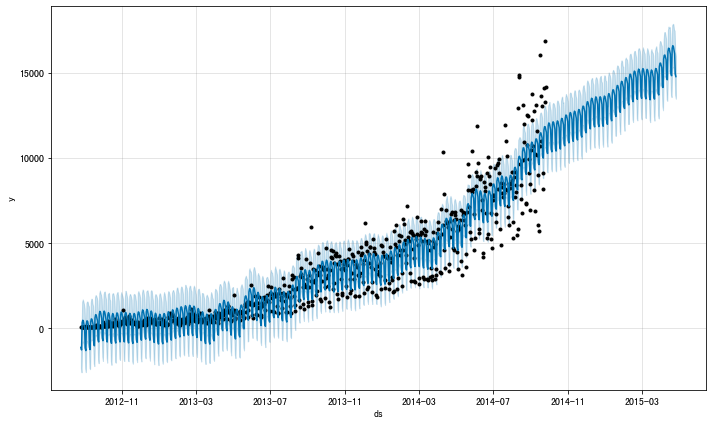

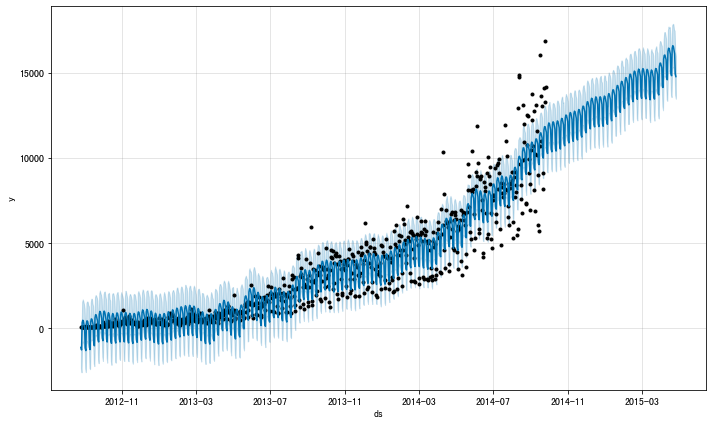

In [52]:
#显示结果
model.plot(predict)

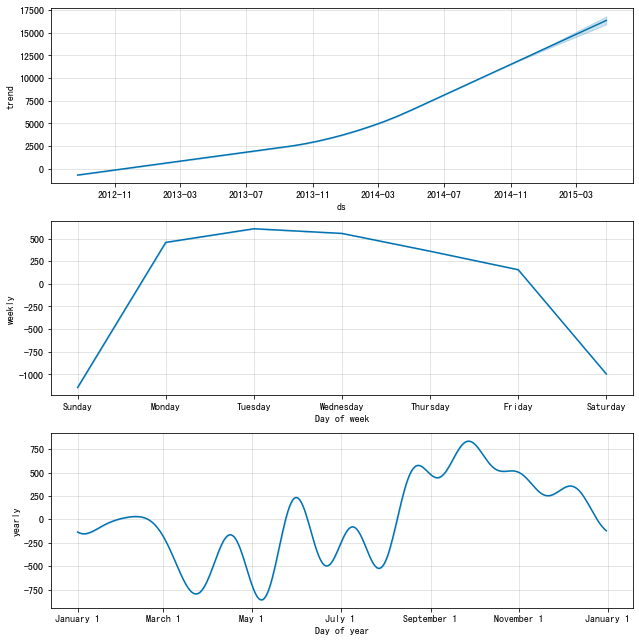

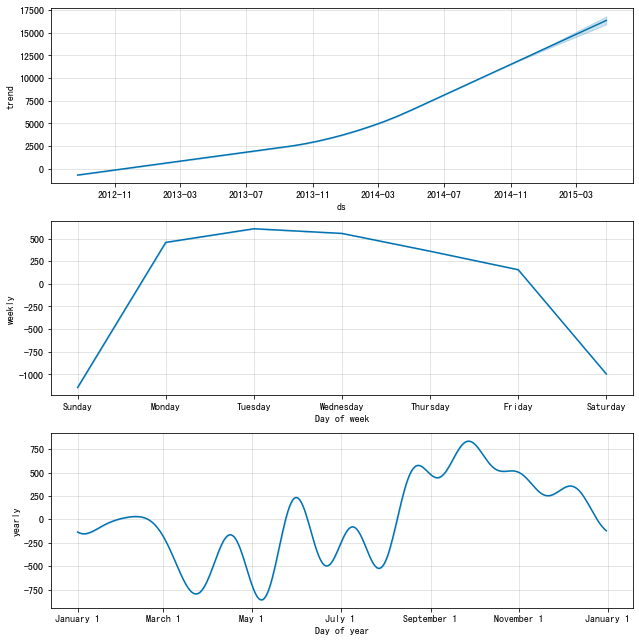

In [53]:
#，展示预测中的趋势、周效应和年度效应
model.plot_components(predict)

In [ ]:
#可见总体趋势是向上的，乘坐交通的人数在递增
#在周效应的图上可见在工作日的乘坐数量较多
#在月效应上可以看出8月底到10月底的乘坐量比较高（可能是因为要游行了。哈哈哈哈哈）


#最后想问老师个问题，为什么plot的时候图会画两遍？？